In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier

# Processing and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import itertools

# Optimization
from scipy.stats import uniform, loguniform
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval
from hyperopt.pyll import scope

# NLP
import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re

In [3]:
data = pd.read_csv("./data/competition_data.csv")

## Analisis de datos

In [34]:
pca = PCA(n_components=2)
pca.fit(data.drop(columns=['conversion']))


: 

/tmp/ipykernel_13586/2518070410.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


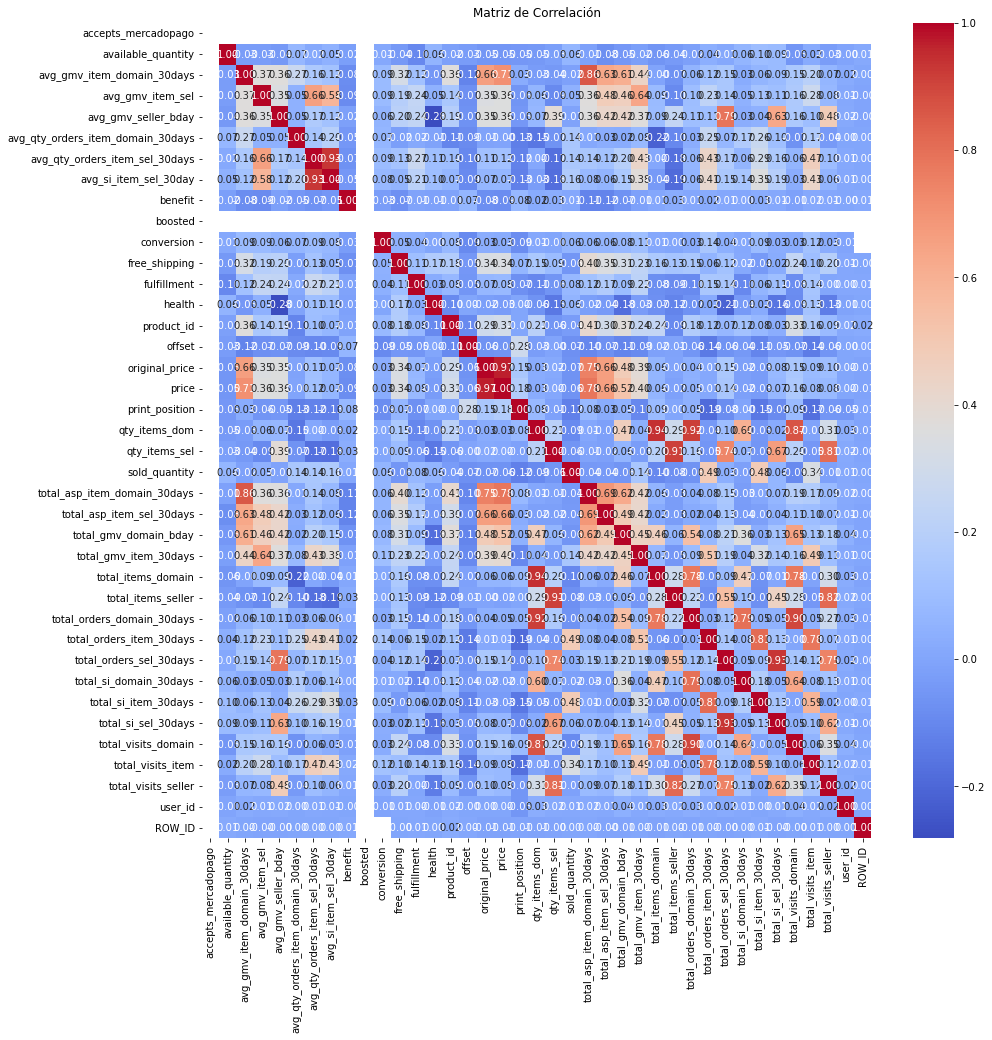

In [3]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [4]:
print(sum(data['accepts_mercadopago'] == True), sum(data['boosted'] == False))

199972 199972


# Procesamiento de datos
Se realiza una selección de variables por filtering. Luego se realizan las conversiones de datos necesarias.

In [4]:
data.drop(columns=['benefit', 'deal_print_id','etl_version', 'accepts_mercadopago', 
                   'item_id', 'main_picture', 'date', 'boosted',
                   'site_id','uid', 'user_id', 'domain_id'], axis= "columns", inplace=True)

# Y casting to bool
data['conversion'] = data['conversion'].astype('bool')

#### Filtering e ingenieria de atributos

Extraemos la cantidad de dias de *warranty* y reemplazamos columna con esos valores

In [5]:
def extract_warr_days(text):
    if len(text) > 80:
        return 0
    matchD = re.search(r'(\d+)\s+d(i|í)as', text)
    matchM = re.search(r'(\d+)\s+m(e|é)ses', text)
    matchY = re.search(r'(\d+)\s+a(n|ñ)os', text)
    if matchD:
        return int(matchD.group(1))
    elif matchM:
        return int(matchM.group(1))*30
    elif matchY:
        return int(matchY.group(1))*365
    else:
        return None
    
data['warranty'] = data['warranty'].fillna("Sin garantia").apply(lambda x: extract_warr_days(x)).fillna(0)

Separamos la fecha en diferente columnas.

In [6]:
data["print_server_timestamp"] = pd.to_datetime(data["print_server_timestamp"])
data["hour"] = data["print_server_timestamp"].dt.hour
data["day"] = data["print_server_timestamp"].dt.day
data["month"] = data["print_server_timestamp"].dt.month
data["day_of_week"] = data["print_server_timestamp"].dt.dayofweek
data['week_of_month'] = data['print_server_timestamp'].apply(lambda d: (d.day-1) // 7 + 1)
data.drop(columns=["print_server_timestamp"], axis= "columns", inplace=True)

Transformamos las variables categoricas con OHE.

In [7]:
data = pd.get_dummies(data, columns = ["platform", "logistic_type"], dummy_na = False, dtype = int)
data["listing_type_id"] = data["listing_type_id"].apply(lambda x: 1 if x == 'gold_pro' else (2 if x == 'gold_special' else x))
data["is_pdp"] = pd.to_numeric(data["is_pdp"], errors="coerce")

La columna tags posee una lista de tags. Creamos una columna para cada uno de los 18 tags que existen, y codificamos segun los tags presentes en cada observacion

In [8]:
data['tags'] = data['tags'].str.strip('][').str.split(', ')
tags = set()
for i in data['tags']:
    for tag in i:
        tags.add("tag_" + tag)
tags = list(tags)

for tag in tags:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

data = data.drop(columns=['tags'], axis= "columns")

La columna full_name posee una cadena de la categoria y subcategorias en las que se encuentra el producto. Extramos la primera de las categorias (mas amplia) y hacemos OHE.

In [9]:
def extract_first_name(x):
    names = x.split("->")
    if len(names) > 1:
        return names[0][:-1]
    else:
        return None

data['category_name'] = data['full_name'].apply(lambda x: extract_first_name(x))
data = data.drop(columns=['full_name'], axis= "columns")
data = pd.get_dummies(data, columns = ["category_name"])

Creamos dos columnas nuevas: una para el descuento en total y otra para el descuento en porcentaje del precio original.

In [10]:
data['discount'] = data['original_price'] - data['price']
data['discount_perc'] = data['discount'] / data['original_price']
data['market_share'] = data['total_si_sel_30days'] / data['total_si_domain_30days']

In [3]:
top_categories = data["category_id"].value_counts().nlargest(10).index
top_product_ids = data["product_id"].value_counts().nlargest(10).index

for category in top_categories:
    data[f"category{category}"] = (data["category_id"] == category).astype(int)

for product_id in top_product_ids:
    data[f"product{product_id}"] = (data["product_id"] == product_id).astype(int)
    
data.drop(columns=["category_id", "product_id"], inplace=True)

NameError: name 'data' is not defined

In [12]:
columns_to_scale = [
    "available_quantity", 
    'avg_gmv_item_domain_30days', 
    'avg_gmv_item_sel', 
    'avg_gmv_seller_bday', 
    'avg_qty_orders_item_domain_30days',
    'avg_qty_orders_item_sel_30days',
    'avg_si_item_sel_30day',
    'health',
    'offset',
    'original_price',
    'price',
    'print_position',
    'qty_items_dom',
    'qty_items_sel',
    'sold_quantity',
    'total_asp_item_domain_30days',
    'total_asp_item_sel_30days',
    'total_gmv_domain_bday',
    'total_gmv_item_30days',
    'total_items_domain',
    'total_items_seller',
    'total_orders_domain_30days',
    'total_orders_item_30days',
    'total_orders_sel_30days',
    'total_si_domain_30days',
    'total_si_item_30days',
    'total_si_sel_30days',
    'total_visits_domain',
    'total_visits_item',
    'total_visits_seller'
    ]
data[columns_to_scale] = np.log1p(data[columns_to_scale])

In [13]:
poly_attrs = ["print_position", "offset", "discount", "price", "health", "original_price", 
              "avg_gmv_item_domain_30days", "avg_gmv_item_sel", "avg_gmv_seller_bday", "avg_qty_orders_item_domain_30days", "avg_qty_orders_item_sel_30days",
              "avg_si_item_sel_30day", "qty_items_dom", "qty_items_sel", "sold_quantity", "total_si_domain_30days", "total_si_sel_30days", "total_si_sel_30days","total_asp_item_domain_30days",
              "total_asp_item_sel_30days","total_asp_item_sel_30days", "total_gmv_domain_bday", "total_gmv_item_30days", "total_orders_item_30days", "total_orders_domain_30days"]

feature_cross = PolynomialFeatures(2)
feature_cross.fit(SimpleImputer(strategy='mean').fit_transform(data[poly_attrs]))
crossed_features = feature_cross.transform(SimpleImputer(strategy='mean').fit_transform(data[poly_attrs]))
crossed_features = pd.DataFrame(crossed_features, columns=feature_cross.get_feature_names_out(poly_attrs))
data = data.join(crossed_features.drop(columns=poly_attrs, axis= "columns"))

#### Procesamiento de columna 'title' con w2v

In [15]:
def tokenizer(raw_text):
    """
    Tokeniza y preprocesa un texto.

    Args:
        raw_text (str): Texto sin procesar.

    Returns:
        list: Lista de oraciones, donde cada oración es una lista de palabras.
    """
    sentences = sent_tokenize(raw_text)
    sentences = [word_tokenize(e) for e in sentences]
    sentences = [[e2 for e2 in e1 if re.compile("[A-Za-z]").search(e2[0])] for e1 in sentences]
    sentences = [[e2.lower() for e2 in e1] for e1 in sentences]
    return(sentences)

def average_vectors(title_tokens, model, stopwords=None):
    """
    Calcula el vector promedio de un conjunto de tokens utilizando un modelo Word2Vec.

    Args:
        title_tokens (list): Lista de tokens.
        model (gensim.models.Word2Vec): Modelo Word2Vec.
        stopwords (set, optional): Conjunto de palabras stopwords. Defaults to None.

    Returns:
        numpy.ndarray: Vector promedio.
    """
    title_tokens = [e2 for e1 in title_tokens for e2 in e1]
    title_tokens = [e for e in title_tokens if e in model.wv]
    if stopwords is not None:
        title_tokens = [e for e in title_tokens if e not in stopwords]
    if len(title_tokens) == 0:
        output = np.zeros(model.wv.vector_size)
    else:
        output = np.array([model.wv.get_vector(e) for e in title_tokens]).mean(0)
    return output

In [16]:
STOP_WORDS_SP = set(stopwords.words('spanish'))
data["title_tokens"] = data["title"].map(tokenizer)

# Creación del modelo Word2Vec
w2v_tp = gensim.models.Word2Vec(vector_size=30,
                                window=3,
                                min_count=5,
                                negative=10,
                                sample=0.01,
                                workers=8,
                                sg=1)

# Creación del vocabulario a partir del corpus
w2v_tp.build_vocab([e2 for e1 in data["title_tokens"].values for e2 in e1],
                   progress_per=10000)

# Entrenamiento del modelo Word2Vec
w2v_tp.train([e2 for e1 in data["title_tokens"].values for e2 in e1],
             total_examples=w2v_tp.corpus_count,
             epochs=50, report_delay=1)

(74029682, 74992250)

In [17]:
title_embs = data["title_tokens"].map(lambda x: average_vectors(x, w2v_tp, STOP_WORDS_SP))
title_embs = np.array(title_embs.to_list())
data = pd.concat([data, pd.DataFrame(title_embs, columns=[f'emb_{i}' for i in range(30)])], axis=1)

In [18]:
data.drop(columns=["title", "title_tokens"], axis= "columns", inplace=True)

In [19]:
data.to_csv("./data/competition_data_ready.csv", index=False)

# Entrenamiento del modelo

Separamos el dataset en conjunto de Train y Test. Dentro del conjunto de Train dividimos un holdout set para validación con el 20% de las observaciones.

In [4]:
data = pd.read_csv("./data/competition_data_ready.csv")

train_data = data[data["ROW_ID"].isna()]
test_data = data[data["ROW_ID"].notna()]

train_data.columns = train_data.columns.astype(str)
test_data.columns = test_data.columns.astype(str)

x_train = train_data.drop(columns=["conversion", "ROW_ID"])
y_train = train_data["conversion"]

X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=3456)

Se crea un conjunto más pequeño para hacer optimización de hiperparametros

In [ ]:
space2 = {
        "n_estimators": scope.int(hp.uniform("n_estimators", 10, 1000)),
        "learning_rate": hp.loguniform('learning_rate', -5, 0),
        "max_depth": scope.int(hp.quniform('max_depth', 2, 10, 1)),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.uniform('subsample', 0.1, 1),
        "gamma": hp.quniform("gamma", 0.05, 3, 0.05),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
        "reg_lambda": hp.quniform("reg_lambda", 0.01, 2, 0.01),
        "reg_alpha": hp.quniform("reg_alpha", 0, 10, 1),
    }

X_train_min = X_train[:100000]
Y_train_min = Y_train[:100000]

def objective(params):
    tree = xgb.XGBClassifier(**params, random_state = 22)
    tree.fit(X_train_min, Y_train_min)
    score = roc_auc_score(Y_val, tree.predict_proba(X_val)[:, tree.classes_== 1])
    return {'loss': 1 - score, 'status': STATUS_OK}

best = fmin(objective, space = space2,
            algo = tpe.suggest,
            max_evals = 10,
            rstate = np.random.default_rng(22))

best_params_xgb = space_eval(space2, best)
print("BEST PARAMS: ", best_params_xgb)

Se entrena un modelo con los parametros encontrados y se hace evaluacion de la importancia de las variables

In [19]:
best_params_xgb = {'colsample_bytree': 0.4, 'gamma': 0.55, 'learning_rate': 0.013753093395801401, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 938, 'reg_alpha': 8.0, 'reg_lambda': 1.24, 'subsample': 0.24416762766957015}
clf = xgb.XGBClassifier(**best_params_xgb, random_state = 22, objective='binary:logistic')
clf.fit(X_train, Y_train)
print(roc_auc_score(Y_val, clf.predict_proba(X_val)[:, clf.classes_== 1]))
#0.8972610537841871

0.8971496342724941


In [26]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance.head(50)

,feature,importance
0,is_pdp,0.436042
1,offset,0.036932
2,platform_/web/desktop,0.025225
3,print_position,0.015605
4,platform_/mobile/android,0.013020
5,total_orders_item_30days,0.010888
6,"category_name_Electrónica, Audio y Video",0.008628
7,product15582422.0,0.008185
8,product14542731.0,0.007430
9,logistic_type_custom,0.007131


------------------------

In [50]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'max_iter': hp.choice('max_iter', np.arange(100, 500, 10, dtype=int)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(10, 100, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(10, 100, 10, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 10, 1, dtype=int)),
    'l2_regularization': hp.uniform('l2_regularization', 0.01, 0.5),
    'max_bins': hp.choice('max_bins', np.arange(10, 100, 10, dtype=int)),
    'validation_fraction': hp.uniform('validation_fraction', 0.01, 0.5),
    'warm_start': hp.choice('warm_start', [True, False]),
    'early_stopping': hp.choice('early_stopping', [True, False]),
}

X_train_min = X_train[:100000]
Y_train_min = Y_train[:100000]

def objective(params):
    tree =HistGradientBoostingClassifier(**params, random_state = 35)
    tree.fit(X_train_min, Y_train_min)
    score = roc_auc_score(Y_val, tree.predict_proba(X_val)[:, tree.classes_== 1])
    return {'loss': 1 - score, 'status': STATUS_OK}

best = fmin(objective, space = space,
            algo = tpe.suggest,
            max_evals = 10,
            rstate = np.random.default_rng(25))

best_params_hist = space_eval(space, best)
print("BEST PARAMS: ", best_params_hist)

100%|██████████| 10/10 [01:04<00:00,  6.43s/trial, best loss: 0.10866212869558423]
BEST PARAMS:  {'early_stopping': False, 'l2_regularization': 0.1803643748647174, 'learning_rate': 0.20028727436872862, 'max_bins': 80, 'max_depth': 40, 'max_iter': 380, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'validation_fraction': 0.12976509465813624, 'warm_start': False}


Entreno con train

In [ ]:
best_params_hist = {'early_stopping': False, 'l2_regularization': 0.1803643748647174, 'learning_rate': 0.20028727436872862, 'max_bins': 80, 'max_depth': 40, 'max_iter': 380, 'max_leaf_nodes': 20, 'min_samples_leaf': 6, 'validation_fraction': 0.12976509465813624, 'warm_start': False}

hist = HistGradientBoostingClassifier(**best_params_hist, random_state = 35)
hist.fit(X_train, Y_train)
print(roc_auc_score(Y_val, hist.predict_proba(X_val)[:, hist.classes_== 1]))
#0.8958168681170755

In [23]:
# Averge predictions
preds = (
    clf.predict_proba(X_val)[:, clf.classes_== 1] + 
    hist.predict_proba(X_val)[:, hist.classes_== 1]  
    )/2

print(roc_auc_score(Y_val, preds))
#0.898948222450477

0.8982202913787527


Reentreno ambos modelos con el dataset completo

In [ ]:
hist = HistGradientBoostingClassifier(**best_params_hist, random_state = 35)
hist.fit(x_train, y_train)

clf = xgb.XGBClassifier(**best_params_xgb, random_state = 22)
clf.fit(x_train, y_train)

In [ ]:
# Averge predictions
preds = (
    clf.predict_proba(X_val)[:, clf.classes_== 1] + 
    hist.predict_proba(X_val)[:, hist.classes_== 1]  
    )/2

Realizamos cross validation para una mejor estimacion del score

In [ ]:
cv = KFold(n_splits=4, random_state=0, shuffle=True)
scores_hist = cross_val_score(hist, x_train, y_train, cv=cv, scoring="roc_auc")
scores_xgb = cross_val_score(clf, x_train, y_train, cv=cv, scoring="roc_auc")
print(scores_hist.mean())
print(scores_xgb.mean())

In [ ]:
y_preds = (clf.predict_proba(X_test)[:, clf.classes_== 1] + hist.predict_proba(X_test)[:, hist.classes_== 1]).squeeze()/2
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_preds})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("./outputs/avg_hist_xgb.csv", sep=",", index=False)